# State Autoencoder

This notebook trains a Transformer autoencoder to reconstruct measurements. It projects the sequential input down to a latent variable, $z$, that should represent the state of the system.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import data.datautil as du
from data.DataUtils import get_ncmapss_dataloaders

from models import TransformerEncoder, TransformerDecoder

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading the data

In [3]:
trainloader, testloader = get_ncmapss_dataloaders(1, 10, 128, 8, subsampled=True)

In [4]:
columns_excluded = [0, 1, 26] # make sure to mask and THEN take these out
training_features = [True, True, True, True,
               True, True, True, True, True, True, True, True, True, True, True, True, True, True,
               True, True, True, True, True, True, True, True, True, True, True, True, True, True,
               False, False, False, False, False, False, False, False, False, False,
               True, True, True, False]

ex_X, ex_y = next(iter(trainloader))
print(f"X Shape: {ex_X[:,:,training_features].shape}, Y Shape: {ex_y.shape}")

X Shape: torch.Size([128, 10, 35]), Y Shape: torch.Size([128, 1])


In [5]:
ex_X.dtype

torch.float32

In [6]:
enc = TransformerEncoder(input_dim=ex_X[:,:,training_features].shape[2], embed_dim=16, dropout=0.1)
dec = TransformerDecoder(output_dim=ex_X[:,:,training_features].shape[2], embed_dim=16, dropout=0.1)

In [7]:
pred = enc(ex_X[:,:,training_features].to(torch.float32))

In [8]:
pred

tensor([[ 0.0265,  0.1114,  0.1047,  ...,  0.0673, -0.1763, -0.0217],
        [ 0.1430,  0.1728,  0.0663,  ...,  0.0356, -0.1705, -0.0734],
        [ 0.1216,  0.1912,  0.0067,  ...,  0.0593, -0.0869, -0.1140],
        ...,
        [ 0.0600,  0.2708,  0.0856,  ...,  0.0194, -0.1440, -0.0012],
        [ 0.1373,  0.2153,  0.1220,  ...,  0.0407, -0.0913, -0.1392],
        [ 0.1183,  0.2224,  0.0144,  ...,  0.0542, -0.1189, -0.0470]],
       grad_fn=<AddmmBackward0>)

In [7]:
torch.std(ex_X)

tensor(0.6193)

In [9]:
xhat = dec(pred)

In [10]:
def plot_latent_space(enc, dataloader):
    zs = []
    enc.eval()
    for X, y in tqdm(dataloader):
        X = X.to(torch.float32).to(device)
        z = enc(X)
        zs.append(z.detach().cpu().numpy())
    
    zs = np.vstack(zs)
    print(zs.shape)
    plt.scatter(zs[:,0], zs[:,1])
    plt.show()
    
    return zs

100%|██████████| 3834/3834 [00:59<00:00, 64.23it/s]


(490663, 2)


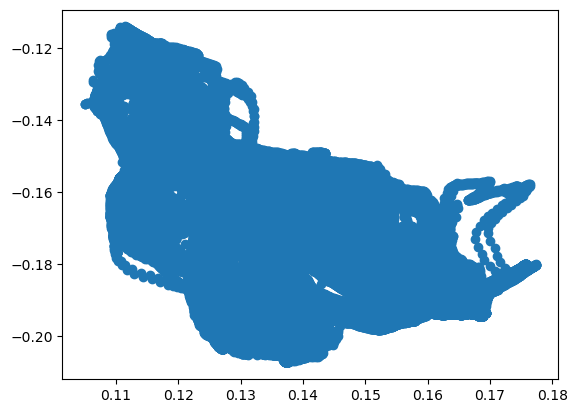

In [12]:
enc = TransformerEncoder(input_dim=ex_X.shape[2], embed_dim=2, dropout=0.1, device=device).to(device)
dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=2, dropout=0.1).to(device)
zs = plot_latent_space(enc, trainloader)

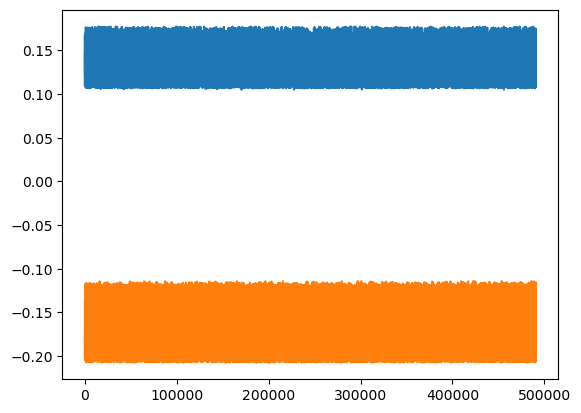

In [13]:
plt.plot(zs)

In [14]:
zs

array([[ 0.12432905, -0.17614248],
       [ 0.12588769, -0.1832165 ],
       [ 0.13570952, -0.16609421],
       ...,
       [ 0.13205534, -0.20053118],
       [ 0.13773769, -0.202287  ],
       [ 0.13767026, -0.19033277]], dtype=float32)

In [11]:
enc = TransformerEncoder(input_dim=ex_X[:,:,training_features].shape[2], embed_dim=16, dropout=0.4, device=device).to(device)
dec = TransformerDecoder(output_dim=ex_X[:,:,training_features].shape[2], embed_dim=16, dropout=0.4).to(device)
objective = nn.MSELoss()
params = list(enc.parameters()) + list(dec.parameters())
    # optimizer
optim = torch.optim.Adam(params, lr=1e-4)

n_epochs = 3
losses = []
for i in tqdm(range(n_epochs)):
    for X, y in trainloader:
        optim.zero_grad()     
        X = X[:,:,training_features].to(torch.float32).to(device)
        y = y.to(device)
        
        z = enc(X)
        Xhat = dec(z)
        
        loss = objective(Xhat, X[:,-1,:])
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
    # plot_latent_space(enc, trainloader)
    # enc.train()
        
    print(f"Epoch: {i+1}, loss: {np.mean(losses[-100:])}")

 33%|███▎      | 1/3 [01:02<02:04, 62.50s/it]

Epoch: 1, loss: 0.004007329544983804


 67%|██████▋   | 2/3 [02:05<01:02, 62.75s/it]

Epoch: 2, loss: 0.0029978659516200425


100%|██████████| 3/3 [03:08<00:00, 62.76s/it]

Epoch: 3, loss: 0.0024158972851000726


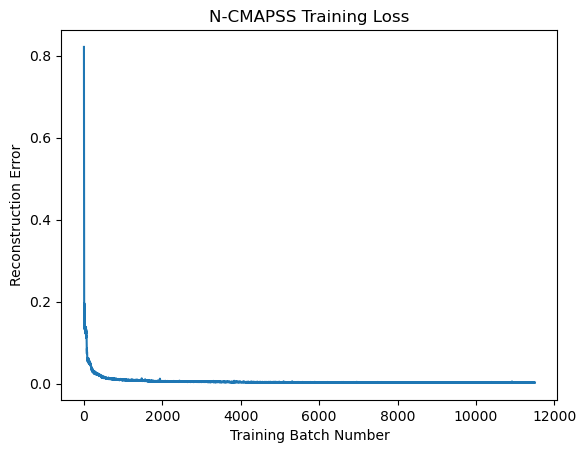

In [21]:
plt.title("N-CMAPSS Training Loss")
plt.ylabel("Reconstruction Error")
plt.xlabel("Training Batch Number")
plt.plot(losses)


In [13]:
errors = []
zs = []
ruls = []
enc.eval()
dec.eval()
for X, y in tqdm(testloader):
    X = X[:,:,training_features].to(torch.float32).to(device)
    
    z = enc(X)
    Xhat = dec(z) 
    
    zs.append(z.detach().cpu().numpy())
    # print(Xhat.shape, X.shape)
    loss = objective(Xhat, X[:,-1,:])
    errors.append(loss.item())
    ruls.append(y.numpy())
    
ruls = np.concatenate(ruls).flatten()
zs = np.vstack(zs)
errors = np.array(errors)

100%|██████████| 2137/2137 [00:33<00:00, 63.17it/s]


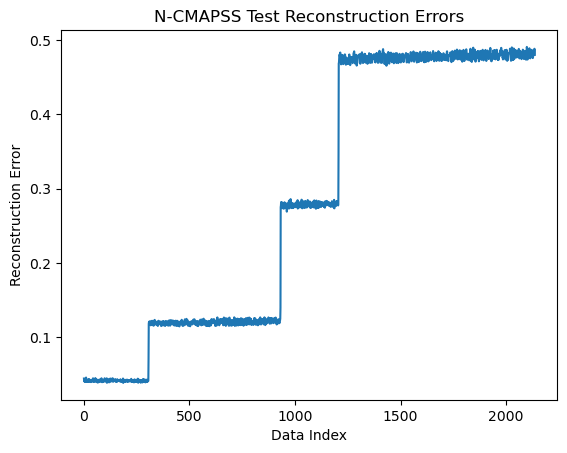

In [19]:
plt.title("N-CMAPSS Test Reconstruction Errors")
plt.xlabel("Data Index")
plt.ylabel("Reconstruction Error")
plt.plot(errors)

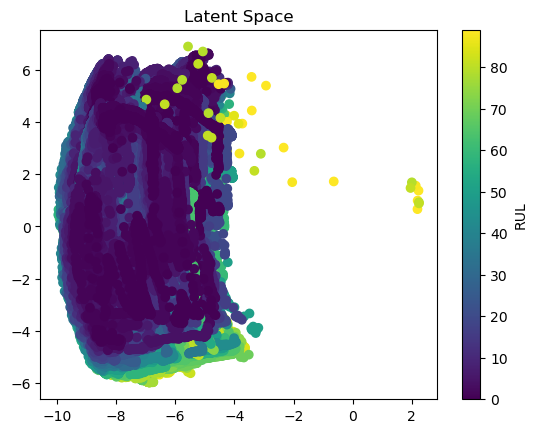

In [15]:
plt.title("Latent Space")
scatter = plt.scatter(zs[:,0], zs[:,1], c=ruls)
cbar = plt.colorbar(scatter)
cbar.set_label('RUL')  # Replace with an appropriate label

plt.show()

In [24]:
np.mean(errors[1500:2000])

0.4785832542181015

In [17]:
torch.save({
    'model_state_dict': enc.state_dict(),
    'positional_embed': enc.positional_embed.data            
}, './saved_models/enc_ncmapss_16dim.pth')
torch.save(dec.state_dict(), './saved_models/dec_ncmapss_16dim.pth')